In [1]:
import os
import pandas as pd
from __future__ import division

import misc.SDH_Conference_TestCases.CaseFuture as cf

from runOpt import get_json
from pkg_resources import resource_filename

In [2]:
repr_days = get_json(resource_filename('TimeSliceSelection', '../Scripts/NoSeasons/ordered_solutions1_20bins_new.txt'))
num_days = 16

### Full optimization

In [3]:
opt_full = cf.setup_opt()

In [4]:
opt_full.compile()
opt_full.set_objective('energy')

In [5]:
opt_full.solve(tee=True, solver='gurobi')

Academic license - for non-commercial use only
Read LP format model from file C:\Users\u0094934\Research\modesto\misc\RepresentativePeriodsMILP\tmpcmsulg.pyomo.lp
Reading time = 4.08 seconds
x490570: 727096 rows, 481810 columns, 1559302 nonzeros
Optimize a model with 727096 rows, 481810 columns and 1559302 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 2e+05]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+02, 1e+04]
  RHS range        [2e-17, 6e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 437172 rows and 305766 columns
Presolve time: 1.61s
Presolved: 289924 rows, 176044 columns, 837657 nonzeros

Ordering time: 0.14s

Barrier statistics:
 Free vars  : 421
 AA' NZ     : 2.114e+06
 Factor NZ  : 4.068e+06 (roughly 200 MBytes of memory)
 Factor Ops : 7.404e+07 (less than 1 second per iteration)
 Threads   

0

## Representative optimization

In [6]:
opt_repr = cf.setup_opt(repr=repr_days[num_days])

In [7]:
opt_repr.compile()
opt_repr.set_objective('energy')

In [8]:
opt_repr.solve(tee=True, solver='gurobi')

Academic license - for non-commercial use only
Read LP format model from file C:\Users\u0094934\Research\modesto\misc\RepresentativePeriodsMILP\tmpyhafg1.pyomo.lp
Reading time = 0.21 seconds
x20086: 33342 rows, 19702 columns, 74222 nonzeros
Optimize a model with 33342 rows, 19702 columns and 74222 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 2e+05]
  Objective range  [7e-03, 1e+00]
  Bounds range     [1e+02, 3e+06]
  RHS range        [4e-16, 6e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15412 rows and 12628 columns
Presolve time: 0.11s
Presolved: 17930 rows, 7074 columns, 56105 nonzeros

Ordering time: 0.39s

Barrier statistics:
 Dense cols : 32
 Free vars  : 22
 AA' NZ     : 3.569e+05
 Factor NZ  : 1.932e+06 (roughly 26 MBytes of memory)
 Factor Ops : 6.460e+08 (less than 1 second per iteration)
 Threads   

0

## Analyze results

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')

<IPython.core.display.Javascript object>


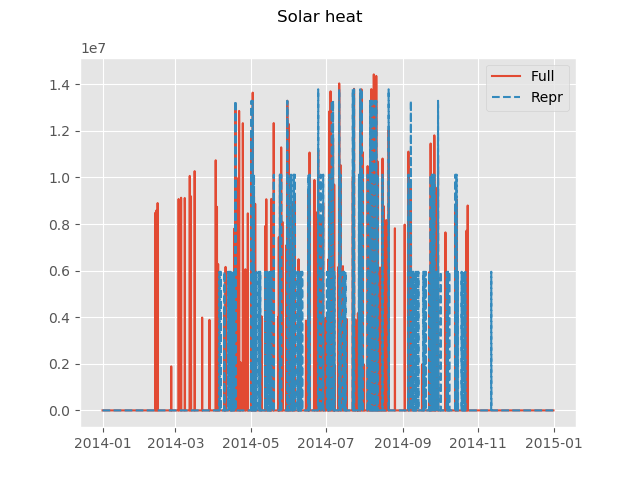

In [26]:
fig, ax = plt.subplots()

full_sol = opt_full.get_result('heat_flow', node='SolarArray', comp='solar')
repr_sol = opt_repr.get_result('heat_flow', node='SolarArray', comp='solar')

fig.suptitle('Solar heat')
ax.plot(full_sol, label='Full')
ax.plot(repr_sol, '--', label='Repr')

ax.legend()

<IPython.core.display.Javascript object>


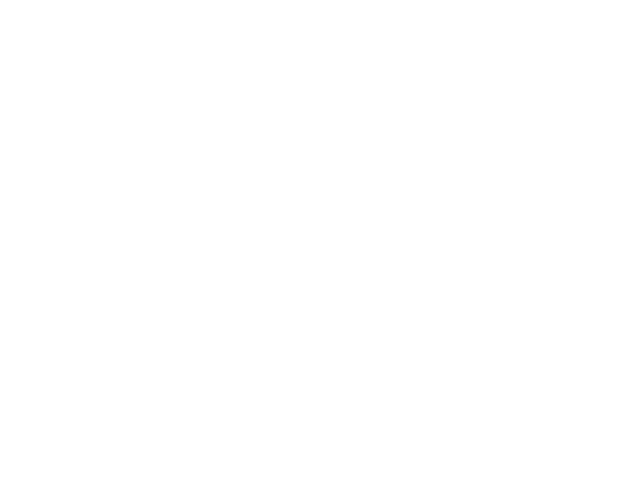

In [11]:
fig, ax = plt.subplots()

ax.scatter(full_sol.values, repr_sol.values)

<IPython.core.display.Javascript object>


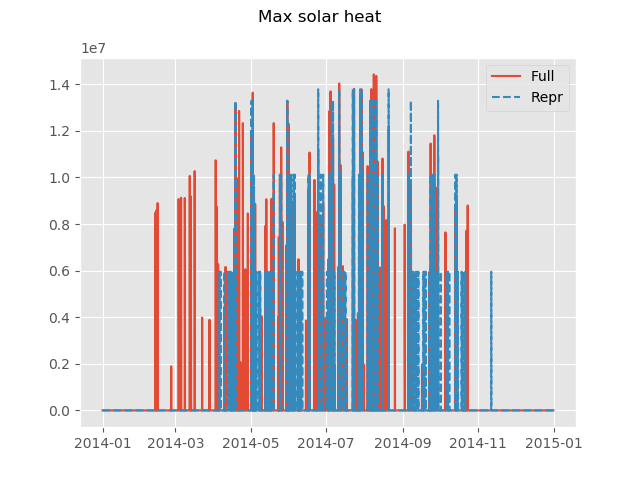

In [27]:
fig, ax = plt.subplots()

full_sol_max = opt_full.get_result('heat_flow_max', node='SolarArray', comp='solar')
repr_sol_max = opt_repr.get_result('heat_flow_max', node='SolarArray', comp='solar')

fig.suptitle('Max solar heat')
ax.plot(full_sol, label='Full')
ax.plot(repr_sol, '--', label='Repr')

ax.legend()

## Compare TSS and modesto data

In [28]:
import numpy as np

def choose_day(df, day):
    return np.array(df[df.index.dayofyear == day+1].values)

def reconstruct(data, repr_d):
    data=data['2014']
    data_restor = []
    for d in xrange(365):
        data_restor.append(choose_day(data, int(repr_d[d])))
    return pd.Series(name=data.name, index=data.index, data=np.concatenate(tuple(data_restor)))


<IPython.core.display.Javascript object>


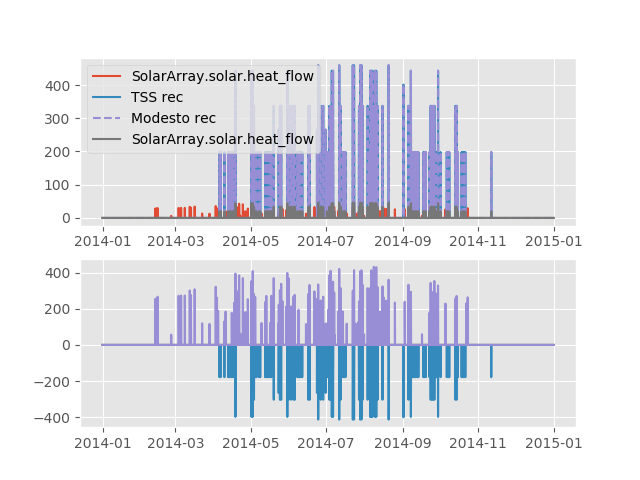

In [29]:
import modesto.utils as utils
tss_data = utils.read_time_data(resource_filename('TimeSliceSelection', 'Data/Renewable'), name='NewSolarThermal.csv')['0_40']
mod_data = utils.read_time_data(resource_filename('modesto', 'Data/RenewableProduction'), name='NewSolarThermal_TSS.csv')['0_40']

tss_data = tss_data.resample('1H').mean()
mod_data = mod_data.resample('1H').mean()



rec_tss_data = reconstruct(tss_data, repr_days[num_days])
rec_mod_data = reconstruct(mod_data, repr_days[num_days])
fig, ax = plt.subplots(2, 1)

#ax[0].plot(tss_data, label= 'TSS')
#ax[0].plot(mod_data, label='Modesto')

ax[0].plot(full_sol/300000, '-')
ax[0].plot(rec_tss_data, '-', label='TSS rec')
ax[0].plot(rec_mod_data, '--', label='Modesto rec')
ax[0].plot(repr_sol/300000, '-')


ax[1].plot(rec_tss_data-rec_mod_data)
ax[1].plot(repr_sol/300000 - rec_mod_data)
ax[1].plot(mod_data - full_sol/300000)

ax[0].legend()

In [31]:
print rec_tss_data.sum()
print rec_mod_data.sum()
print repr_sol.sum()/3e4
print full_sol.sum()/3e4
print mod_data.sum()

109982.92639923096
109982.92639923096
107455.45368192667
108505.04368210469
108505.04368209839


In [32]:
test= pd.DataFrame()
test['Full sol'] = full_sol
test['Repr sol'] = repr_sol
test.head()

,Full sol,Repr sol
2014-01-01 00:00:00,0.0,0.0
2014-01-01 01:00:00,0.0,0.0
2014-01-01 02:00:00,0.0,0.0
2014-01-01 03:00:00,0.0,0.0
2014-01-01 04:00:00,0.0,0.0


In [33]:
print 'Full:',full_sol.sum()
print 'Repr:',repr_sol.sum()

Full: 3255151310.4631405
Repr: 3223663610.4578


<IPython.core.display.Javascript object>


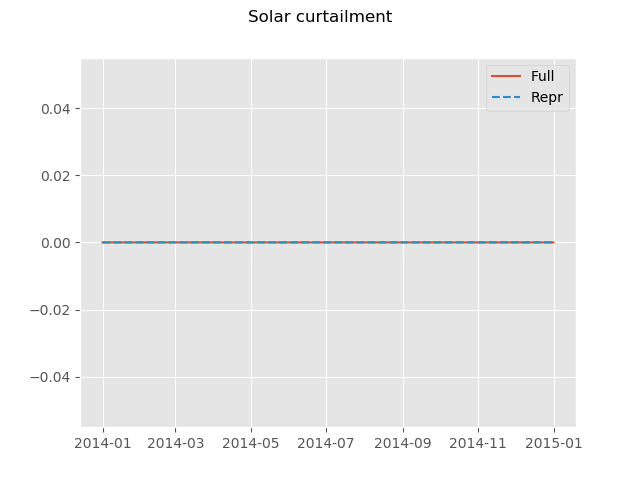

In [34]:
fig, ax = plt.subplots()

full_sol_curt = opt_full.get_result('heat_flow_curt', node='SolarArray', comp='solar')
repr_sol_curt = opt_repr.get_result('heat_flow_curt', node='SolarArray', comp='solar')

fig.suptitle('Solar curtailment')
ax.plot(full_sol_curt, label='Full')
ax.plot(repr_sol_curt, '--', label='Repr')

ax.legend()

<IPython.core.display.Javascript object>


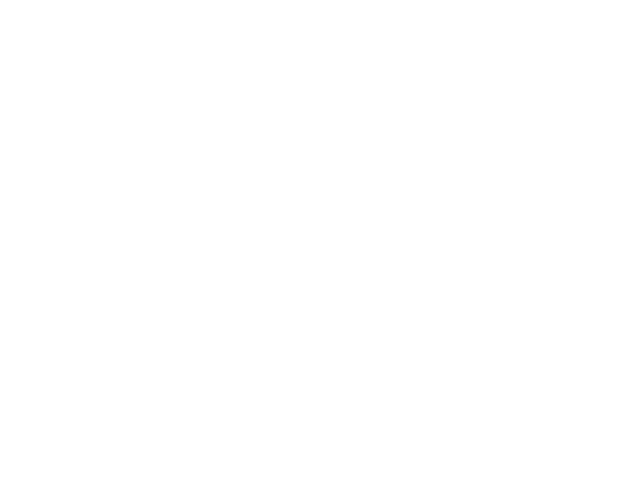

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True)
cols = {
    'SolarArray': 'yellowgreen', 
    'TermienWest': 'darkblue', 
    'WaterscheiGarden': 'chocolate', 
    'Production': 'dimgrey'
}
repr_ls = []
full_ls = []
for node in ['SolarArray', 'TermienWest', 'WaterscheiGarden', 'Production']:
    ax[0].plot(opt_repr.get_result('heat_flow', node=node, comp='tank').cumsum(), label=node, color=cols[node])
    ax[0].plot(opt_full.get_result('heat_flow', node=node, comp='tank').cumsum(), label=None, linestyle=':', color=cols[node])
    
    repr_ls.append(opt_repr.get_result('heat_flow', node=node, comp='tank'))
    full_ls.append(opt_full.get_result('heat_flow', node=node, comp='tank'))

ax[1].plot(pd.concat(repr_ls, axis=1).sum(axis=1).cumsum()/1e3)
ax[1].plot(pd.concat(full_ls, axis=1).sum(axis=1).cumsum()/1e3, ':')
ax[0].legend()

<IPython.core.display.Javascript object>


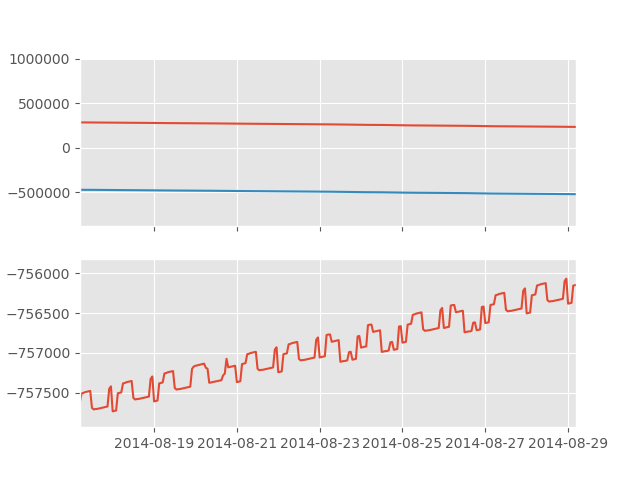

In [41]:
fig, ax = plt.subplots(2,1 , sharex=True)
axr = ax[0]  #.twinx()
axr.plot(opt_repr.get_result('heat_stor', node='TermienWest', comp='tank'))

ax[0].plot(opt_repr.get_result('heat_flow', node='TermienWest', comp='tank').cumsum()/1000)

ax[1].plot(opt_repr.get_result('heat_flow', node='TermienWest', comp='tank').cumsum()/1000 - opt_repr.get_result('heat_stor', node='TermienWest', comp='tank'))

In [21]:
full_soc = np.vstack([opt_full.get_result('heat_stor', node='TermienWest', comp='tank').values, 
                      opt_full.get_result('heat_stor', node='WaterscheiGarden', comp='tank').values, 
                      opt_full.get_result('heat_stor', node='SolarArray', comp='tank').values])
repr_soc = np.vstack([opt_repr.get_result('heat_stor', node='TermienWest', comp='tank').values, 
                      opt_full.get_result('heat_stor', node='WaterscheiGarden', comp='tank').values, 
                      opt_full.get_result('heat_stor', node='SolarArray', comp='tank').values])
print full_soc

[[      0.              0.              0.        ...       0.
        0.              0.       ]
 [1752919.19148   1768486.03797   1789429.97078   ... 1735792.41237
  1742253.93494   1752919.19148  ]
 [  11225.7338461   11216.014572    11206.2633837 ...   11248.019244
    11236.9026793   11225.7338461]]


In [22]:
for i in full_soc:
    print len(i)
for i in repr_soc:
    print len(i)

8761
8761
8761
8761
8761
8761


<IPython.core.display.Javascript object>


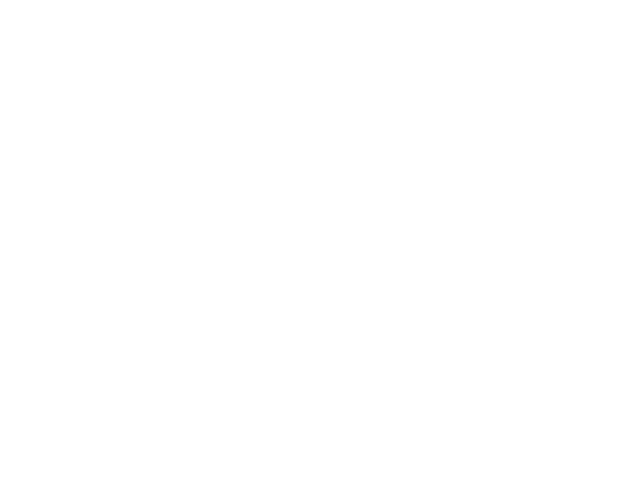

In [23]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].stackplot(np.arange(0, 8761), full_soc)
ax[1].stackplot(np.arange(0, 8761), repr_soc)

C:\Users\u0094934\AppData\Local\Continuum\miniconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


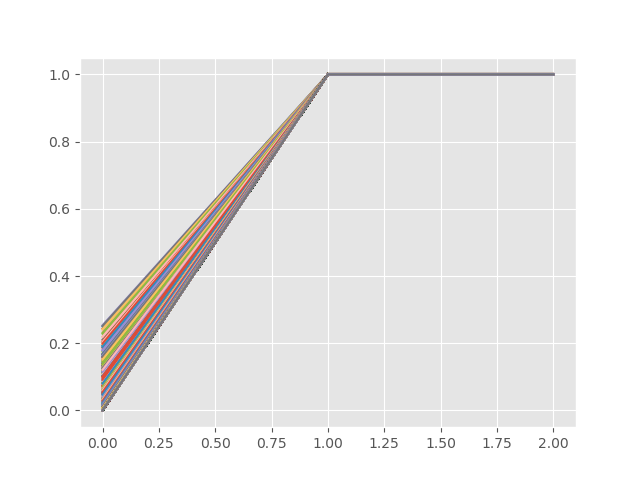

 ...]

In [24]:
%matplotlib notebook
plt.plot(full_soc/repr_soc)

<IPython.core.display.Javascript object>


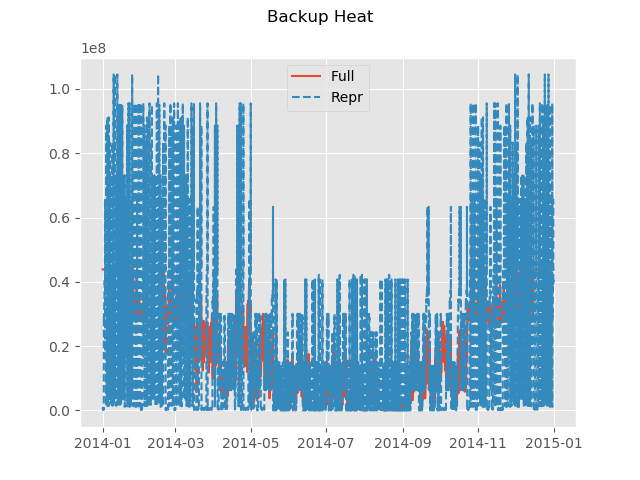

In [25]:
fig, ax = plt.subplots()

full_backup = opt_full.get_result('heat_flow', node='Production', comp='backup')
repr_backup = opt_repr.get_result('heat_flow', node='Production', comp='backup')

fig.suptitle('Backup Heat')
ax.plot(full_backup, label='Full')
ax.plot(repr_backup, '--', label='Repr')

ax.legend()